In [12]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [43]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,34022,None,None,85800.809184
2020-06-13,34023,None,None,79715.133799
2020-06-14,34024,None,None,74062.769119
2020-06-15,34025,None,None,68737.992456
2020-06-16,34026,None,None,63995.501082
...,...,...,...,...
2021-02-22,34277,None,None,163019.630106
2021-02-23,34278,None,None,159078.630850
2021-02-24,34279,None,None,155961.025583


In [44]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-26_2021-02-26-11-43.pickle


In [45]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-23_2021-02-23-19-20.pickle


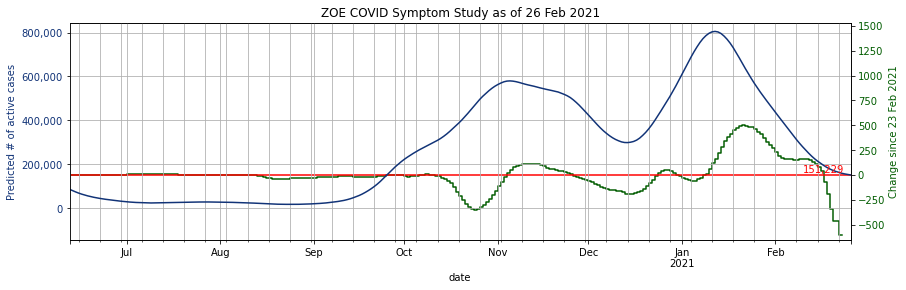

In [46]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

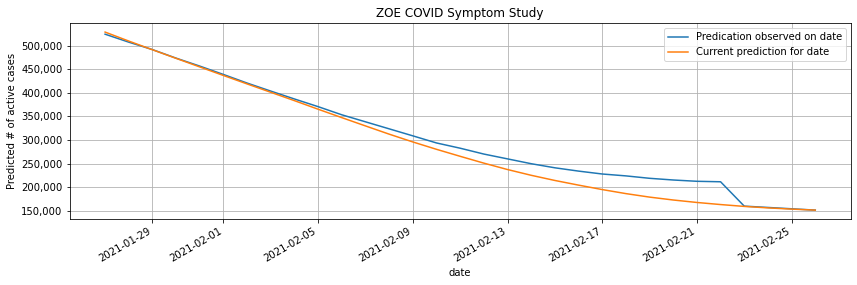

In [47]:
plot_study_evolution(curr_date, days=30)

In [48]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [49]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-02-26_2021-02-26-11-43.pickle


In [50]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
45,Bedford,E06000055,1.013609
25,Leicester,E06000016,0.993081
323,North Lanarkshire,S12000044,0.761403
15,"Kingston upon Hull, City of",E06000010,0.757858
295,East Renfrewshire,S12000011,0.732967
26,Rutland,E06000017,0.728507
280,Doncaster,E08000017,0.721014
342,Bridgend,W06000013,0.713398
71,South Derbyshire,E07000039,0.689733
297,Falkirk,S12000014,0.660792
